# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


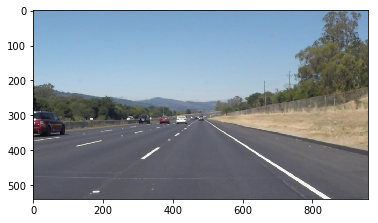

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [347]:
class LaneDetection:
    def __init__(self,
                 buffer_size=10,
                 kernel_size=3,
                 canny_lo_thresh=20,
                 canny_hi_thresh=60,
                 hough_rho=2,
                 hough_theta=(np.pi/180),
                 hough_thresh=50,
                 hough_min_line_len=15,
                 hough_max_line_gap=10,
                 min_line_slope=0.5,
                 max_line_slope=0.9,
                 line_color=[255, 0, 0]):
        self.buffer_size = buffer_size
        self.kernel_size = kernel_size
        self.canny_lo_thresh = canny_lo_thresh
        self.canny_hi_thresh = canny_hi_thresh
        self.hough_rho = hough_rho
        self.hough_theta = hough_theta
        self.hough_thresh = hough_thresh
        self.hough_min_line_len = hough_min_line_len
        self.hough_max_line_gap = hough_max_line_gap
        self.min_line_slope = min_line_slope
        self.max_line_slope = max_line_slope
        self.line_color = line_color
        self.left_buffer = []
        self.right_buffer = []

    def filter_colors_hsv(self, img):
        """
        Convert image to HSV color space and suppress any colors
        outside of the defined color ranges
        """
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        yellow_dark = np.array([15, 127, 127], dtype=np.uint8)
        yellow_light = np.array([25, 255, 255], dtype=np.uint8)
        yellow_range = cv2.inRange(img, yellow_dark, yellow_light)

        white_dark = np.array([0, 0, 200], dtype=np.uint8)
        white_light = np.array([255, 30, 255], dtype=np.uint8)
        white_range = cv2.inRange(img, white_dark, white_light)

        return cv2.bitwise_and(img, img, mask=(yellow_range | white_range))

    def get_masked_image(self, img):
        """
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        rows, cols = img.shape[:2]
        top = int(rows/2 + 50)
        vertices = np.array([[(      30, rows),
                              (     450,  top),
                              (cols-450,  top),
                              ( cols-30, rows)]], dtype=int)
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, vertices, 255)
        return img & mask

    def add_line_to_buffer(self, line, buffer):
        """
        Push the current line onto this buffer and drop the oldest line
        if there are more lines than the specified buffer size
        """
        buffer.append(line)
        return buffer[-self.buffer_size:]

    def get_line_segment(self, x1, x2, line):
        """
        Use the slope and y-intercept values of the line to derive
        the y1,y2 values for the inputs x1,x2
        """
        fx = np.poly1d(line)
        y1 = int(fx(x1))
        y2 = int(fx(x2))
        return ((x1,y1), (x2,y2))
    
    def get_line_intersection(self, left_line, right_line):
        """
        find the intersection of 2 lines
        """
        left_slope, left_intercept = left_line
        right_slope, right_intercept = right_line
        
        # put the coordinates into homogeneous form
        a = [[left_slope, -1],
             [right_slope, -1]]
        b = [-left_intercept, -right_intercept]
        x, y = np.linalg.solve(a, b)
        return int(x)
    
    def partition_line_segments(self, line_segments, mid_x):
        """
        Separates line segments by their position in the image to determine which is the
        left line vs. the right line. Filter out line segments with slopes outside a
        given minimum / maxiumum
        """
        left_points = {'X': [], 'Y': [],}
        right_points = {'X': [], 'Y': [],}
        for segment in line_segments:
            x1, y1, x2, y2 = segment[0]
            dY = y2 - y1
            dX = x2 - x1
            if dX != 0: # don't divide by zero
                slope = float(dY) / float(dX)
                if x1 < mid_x and x2 < mid_x: # left lines
                    if -self.max_line_slope < slope < -self.min_line_slope:
                        left_points['X'] += [x1,x2]
                        left_points['Y'] += [y1,y2]
                elif x1 > mid_x and x2 > mid_x: # right lines
                    if self.max_line_slope > slope > self.min_line_slope:
                        right_points['X'] += [x1,x2]
                        right_points['Y'] += [y1,y2]
        return left_points, right_points
    
    def fit_lines_to_points(self, left_points, right_points):
        """
        fit a line (slope, y-intercept) to each of the point sets and add to buffer
        return the average slope and y-intercept values over the last N frames
        """
        if len(left_points['X']) > 1:
            left_line = np.polyfit(left_points['X'], left_points['Y'], 1)
            self.left_buffer = self.add_line_to_buffer(left_line, self.left_buffer)
        if len(right_points['X']) > 1:
            right_line = np.polyfit(right_points['X'], right_points['Y'], 1)
            self.right_buffer = self.add_line_to_buffer(right_line, self.right_buffer)
        
        return (np.mean(self.left_buffer, axis=0),
                np.mean(self.right_buffer, axis=0),)

    def get_lane_lines(self, img):
        left_x = 0
        right_x = img.shape[1]
        line_segments = cv2.HoughLinesP(img, self.hough_rho, self.hough_theta, self.hough_thresh,
                                        minLineLength=self.hough_min_line_len,
                                        maxLineGap=self.hough_max_line_gap)
        left_points, right_points = self.partition_line_segments(line_segments, int(right_x / 2))
        left_line, right_line = self.fit_lines_to_points(left_points, right_points)
        intersection_x = self.get_line_intersection(left_line, right_line)

        return (self.get_line_segment(left_x, intersection_x, left_line),
                self.get_line_segment(right_x, intersection_x, right_line),)
    
    def get_filtered_masked_image(self, img):
        filtered_img = self.filter_colors_hsv(img)
        filtered_img = cv2.GaussianBlur(filtered_img[:,:,2], (self.kernel_size, self.kernel_size), 0)
        filtered_img = cv2.Canny(filtered_img, self.canny_lo_thresh, self.canny_hi_thresh)
        return self.get_masked_image(filtered_img)
    
    def process_image(self, img):
        filtered_img = self.get_filtered_masked_image(img)
        lane_lines = self.get_lane_lines(filtered_img)
        line_img = np.zeros_like(img)
        for line in lane_lines:
            cv2.line(line_img, line[0], line[1], self.line_color, 5)
        return cv2.addWeighted(img, 1., line_img, 1., 0.)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [343]:
# Import everything needed to edit/save/watch video clips
# import imageio
# imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

CPU times: user 61.6 ms, sys: 4.14 ms, total: 65.8 ms
Wall time: 58.6 ms


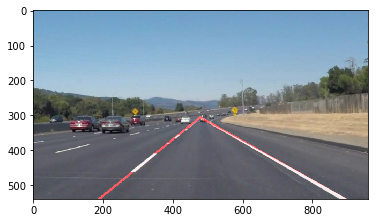

In [348]:
import os
imlist = os.listdir("test_images")
im = mpimg.imread("test_images/{}".format(imlist[0]))

ld = LaneDetection()
%time plt.imshow(ld.process_image(im))

In [262]:
ld = LaneDetection()

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(ld.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 81.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.39 s, sys: 591 ms, total: 3.98 s
Wall time: 3.11 s


In [263]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(ld.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [351]:
challenge_output = 'extra-buffered.mp4'
clip2 = VideoFileClip('challenge.mp4')
ld = LaneDetection()

challenge_clip = clip2.fl_image(ld.process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra-buffered.mp4
[MoviePy] Writing video extra-buffered.mp4


100%|██████████| 251/251 [00:06<00:00, 41.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra-buffered.mp4 

CPU times: user 6.82 s, sys: 967 ms, total: 7.78 s
Wall time: 6.93 s


In [352]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))